<a href="https://colab.research.google.com/github/Dewdiii/Forecasting-Industry-Growth-Based-on-Historical-Trade-Data-Exports-Imports-in-Sri-Lanka./blob/main/ImpExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose ImpExp.zip

Saving ImpExp.zip to ImpExp.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("ImpExp.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")  # extracts to data/ImpExp/

In [ ]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

## Build the Dataset

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_industry_data(industry):
    all_csvs = os.listdir(data_dir.format(industry))
    all_csvs = [f for f in all_csvs if f.endswith(".xlsx")]
    all_csv_paths = [os.path.join(data_dir.format(industry), f) for f in all_csvs]

    all_data = []
    for csv in all_csv_paths:
        df = pd.read_excel(csv, sheet_name='Partner')
        df['Partner Name'] = df['Partner Name'].str.strip()
        df = df[df['Partner Name'] == 'World']
        assert len(df) == 1, f"More than one or no 'World' data found in {csv}"

        df = df[[
            'Year',
            'Export (US$ Thousand)',      # index 0 (Y1)
            'Import (US$ Thousand)',      # index 1 (Y2)
            'Revealed comparative advantage',
            'World Growth (%)',
            'Country Growth (%)',
            'AHS Simple Average (%)',
            'AHS Dutiable Tariff Lines Share (%)',
        ]]
        df.reset_index(drop=True, inplace=True)
        all_data.append(df)

    all_data = pd.concat(all_data).reset_index(drop=True)
    all_data.fillna(all_data.mean(), inplace=True)
    all_data = all_data.astype(float)
    all_data.sort_values(by='Year', inplace=True)

    # Separate columns
    targets = all_data[['Export (US$ Thousand)', 'Import (US$ Thousand)']].copy()
    features = all_data.drop(columns=['Year', 'Export (US$ Thousand)', 'Import (US$ Thousand)'])

    # Scale targets separately
    scaler_Y1 = StandardScaler()
    scaler_Y2 = StandardScaler()

    Y1_scaled = scaler_Y1.fit_transform(targets[['Export (US$ Thousand)']])
    Y2_scaled = scaler_Y2.fit_transform(targets[['Import (US$ Thousand)']])

    # Scale features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(features)

    # Save scalers
    os.makedirs(os.path.dirname(model_dir.format("")), exist_ok=True)
    pickle.dump(scaler_X, open(model_dir.format(f"{industry} XScalar.pickle"), 'wb'))
    pickle.dump(scaler_Y1, open(model_dir.format(f"{industry} Y1Scalar.pickle"), 'wb'))
    pickle.dump(scaler_Y2, open(model_dir.format(f"{industry} Y2Scalar.pickle"), 'wb'))

    # Combine back into one DataFrame with scaled data
    scaled_df = pd.DataFrame(
        np.concatenate([Y1_scaled, Y2_scaled, X_scaled], axis=1),
        columns=[
            'Export (US$ Thousand)',
            'Import (US$ Thousand)',
            'Revealed comparative advantage',
            'World Growth (%)',
            'Country Growth (%)',
            'AHS Simple Average (%)',
            'AHS Dutiable Tariff Lines Share (%)'
        ]
    )

    return scaled_df

def make_ts_dataset(industry, window_size=7, split=0.8):
    df = load_industry_data(industry)

    try:
        scaler = pickle.load(open(model_dir.format(f"{industry} Scalar.pickle"), 'rb'))
    except FileNotFoundError:
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        scaler.fit(df)
        pickle.dump(scaler, open(model_dir.format(f"{industry} Scalar.pickle"), 'wb'))

    scaled = scaler.transform(df)

    X, Y1, Y2 = [], [], []
    for i in range(len(scaled) - window_size):
        window = scaled[i:i+window_size]
        next_point = scaled[i+window_size]
        X.append(window)
        Y1.append(next_point[0])
        Y2.append(next_point[1])

    X = np.array(X)
    Y1 = np.array(Y1)
    Y2 = np.array(Y2)

    split_index = int(len(X) * split)
    return X[:split_index], Y1[:split_index], Y2[:split_index], X[split_index:], Y1[split_index:], Y2[split_index:]

### Load Sample Data

In [ ]:
X_train, Y1_train, Y2_train, X_test, Y1_test, Y2_test = make_ts_dataset('Agricultural Raw Materials')

print("Train X shape:", X_train.shape)
print("Train Import Y1 shape:", Y1_train.shape)
print("Train Export Y2 shape:", Y2_train.shape)

print("Test X shape:", X_test.shape)
print("Test Import Y1 shape:", Y1_test.shape)
print("Test Export Y2 shape:", Y2_test.shape)

Train X shape: (7, 7, 7)
Train Import Y1 shape: (7,)
Train Export Y2 shape: (7,)
Test X shape: (2, 7, 7)
Test Import Y1 shape: (2,)
Test Export Y2 shape: (2,)


# Baseline Models

In [ ]:
import numpy as np
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_growth_rate(predicted, last_actual):
    if last_actual == 0:
        return 0
    return ((predicted - last_actual) / last_actual) * 100

def baseline_training_evaluation(industry, window_size=3):
    # Load data and scaler
    df = load_industry_data(industry)  # assumed shape: [time_steps, 2] with columns [export, import]
    scaler_Y1 = pickle.load(open(model_dir.format(f"{industry} Y1Scalar.pickle"), 'rb'))
    scaler_Y2 = pickle.load(open(model_dir.format(f"{industry} Y2Scalar.pickle"), 'rb'))

    # Inverse transform export and import separately
    export_series = scaler_Y1.inverse_transform(df[['Export (US$ Thousand)']]).flatten()
    import_series = scaler_Y2.inverse_transform(df[['Import (US$ Thousand)']]).flatten()

    def evaluate_series(series, label):
        print(f"\n--- {label} ---")

        # Naive predictions: previous year's value (shifted by 1)
        naive_preds = series[:-1]
        naive_actuals = series[1:]

        # SMA predictions (window_size)
        sma_preds = []
        sma_actuals = []
        for i in range(window_size, len(series)):
            window = series[i - window_size:i]
            sma_preds.append(np.mean(window))
            sma_actuals.append(series[i])

        # --- Naive Metrics ---
        naive_mae = mean_absolute_error(naive_actuals, naive_preds)
        naive_mse = mean_squared_error(naive_actuals, naive_preds)
        naive_rmse = np.sqrt(naive_mse)
        naive_mean_actual = np.mean(np.abs(naive_actuals))
        naive_mape = (naive_mae / naive_mean_actual) * 100
        naive_acc = 100 - naive_mape

        # --- SMA Metrics ---
        sma_mae = mean_absolute_error(sma_actuals, sma_preds)
        sma_mse = mean_squared_error(sma_actuals, sma_preds)
        sma_rmse = np.sqrt(sma_mse)
        sma_mean_actual = np.mean(np.abs(sma_actuals))
        sma_mape = (sma_mae / sma_mean_actual) * 100
        sma_acc = 100 - sma_mape

        # Print results
        print("Naïve Accuracy:")
        print(f"  MAE:  {naive_mae:.2f}")
        print(f"  MSE:  {naive_mse:.2f}")
        print(f"  RMSE: {naive_rmse:.2f}")
        print(f"  MAPE: {naive_mape:.2f}%")
        print(f"  Accuracy: {naive_acc:.2f}%")

        print("SMA Accuracy:")
        print(f"  MAE:  {sma_mae:.2f}")
        print(f"  MSE:  {sma_mse:.2f}")
        print(f"  RMSE: {sma_rmse:.2f}")
        print(f"  MAPE: {sma_mape:.2f}%")
        print(f"  Accuracy: {sma_acc:.2f}%")

        # Growth rate prediction
        last_actual = series[-2]  # second last actual value
        naive_pred = series[-2]   # naive = previous actual
        sma_pred = np.mean(series[-window_size - 1:-1])  # SMA window before last known

        naive_growth = get_growth_rate(naive_pred, last_actual)
        sma_growth = get_growth_rate(sma_pred, last_actual)

        print(f"Naive Predicted Growth: {naive_growth:.2f}%")
        print(f"SMA Predicted Growth:   {sma_growth:.2f}%")

    print(f"\n Baseline Training Evaluation for Industry: {industry} (window={window_size})")

    evaluate_series(export_series, "Export")
    evaluate_series(import_series, "Import")

In [ ]:
baseline_training_evaluation('Agricultural Raw Materials', window_size=3)


 Baseline Training Evaluation for Industry: Agricultural Raw Materials (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  45766.05
  MSE:  2952697504.69
  RMSE: 54338.73
  MAPE: 15.91%
  Accuracy: 84.09%
SMA Accuracy:
  MAE:  55336.34
  MSE:  4631915570.28
  RMSE: 68058.18
  MAPE: 18.17%
  Accuracy: 81.83%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   -10.98%

--- Import ---
Naïve Accuracy:
  MAE:  53988.11
  MSE:  4708589783.71
  RMSE: 68619.16
  MAPE: 21.87%
  Accuracy: 78.13%
SMA Accuracy:
  MAE:  72405.66
  MSE:  7534516973.21
  RMSE: 86801.60
  MAPE: 27.58%
  Accuracy: 72.42%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   10.05%


In [ ]:
baseline_training_evaluation('Consumer Goods', window_size=3)


 Baseline Training Evaluation for Industry: Consumer Goods (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  720244.59
  MSE:  674797320163.76
  RMSE: 821460.48
  MAPE: 9.55%
  Accuracy: 90.45%
SMA Accuracy:
  MAE:  748797.27
  MSE:  783966067576.76
  RMSE: 885418.58
  MAPE: 9.47%
  Accuracy: 90.53%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   6.09%

--- Import ---
Naïve Accuracy:
  MAE:  947863.18
  MSE:  1247659704340.62
  RMSE: 1116986.89
  MAPE: 19.17%
  Accuracy: 80.83%
SMA Accuracy:
  MAE:  866368.67
  MSE:  1284660347203.94
  RMSE: 1133428.58
  MAPE: 16.43%
  Accuracy: 83.57%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   29.17%


In [ ]:
baseline_training_evaluation('Transportation', window_size=3)


 Baseline Training Evaluation for Industry: Transportation (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  75888.57
  MSE:  9614073131.04
  RMSE: 98051.38
  MAPE: 37.46%
  Accuracy: 62.54%
SMA Accuracy:
  MAE:  69039.73
  MSE:  7272176443.70
  RMSE: 85277.06
  MAPE: 32.63%
  Accuracy: 67.37%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   68.87%

--- Import ---
Naïve Accuracy:
  MAE:  435642.24
  MSE:  289278875556.66
  RMSE: 537846.52
  MAPE: 32.51%
  Accuracy: 67.49%
SMA Accuracy:
  MAE:  525376.91
  MSE:  474184422661.87
  RMSE: 688610.50
  MAPE: 36.58%
  Accuracy: 63.42%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   105.31%


In [ ]:
baseline_training_evaluation('Food Industry', window_size=3)


 Baseline Training Evaluation for Industry: Food Industry (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  48799.68
  MSE:  5101659887.93
  RMSE: 71425.90
  MAPE: 13.01%
  Accuracy: 86.99%
SMA Accuracy:
  MAE:  80596.02
  MSE:  9853026810.03
  RMSE: 99262.41
  MAPE: 19.74%
  Accuracy: 80.26%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   -6.08%

--- Import ---
Naïve Accuracy:
  MAE:  79635.03
  MSE:  9497381160.02
  RMSE: 97454.51
  MAPE: 11.47%
  Accuracy: 88.53%
SMA Accuracy:
  MAE:  105556.13
  MSE:  17843026389.15
  RMSE: 133577.79
  MAPE: 14.26%
  Accuracy: 85.74%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   1.83%


In [ ]:
baseline_training_evaluation('Capital Goods', window_size=3)


 Baseline Training Evaluation for Industry: Capital Goods (window=3)

--- Export ---
Naïve Accuracy:
  MAE:  115110.24
  MSE:  17204406277.59
  RMSE: 131165.57
  MAPE: 23.75%
  Accuracy: 76.25%
SMA Accuracy:
  MAE:  85173.19
  MSE:  11061014503.30
  RMSE: 105171.36
  MAPE: 16.75%
  Accuracy: 83.25%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   20.15%

--- Import ---
Naïve Accuracy:
  MAE:  514694.04
  MSE:  424135416045.69
  RMSE: 651256.80
  MAPE: 16.85%
  Accuracy: 83.15%
SMA Accuracy:
  MAE:  660718.50
  MSE:  642839778910.31
  RMSE: 801772.90
  MAPE: 20.36%
  Accuracy: 79.64%
Naive Predicted Growth: 0.00%
SMA Predicted Growth:   23.49%


## Build, Train, Evaluate model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error
from math import sqrt

# === Model Architecture ===
def build_ts_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(32, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GRU(32),
        tf.keras.layers.Dense(1)
    ])
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer='adam',
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

# === Accuracy and MAPE ===
def calculate_mape_and_accuracy(mae, Y_scaled, scaler):
    Y_scaled = np.array(Y_scaled)
    Y_original = scaler.inverse_transform(Y_scaled.reshape(-1, 1)).flatten()
    mae_original = mae * scaler.scale_[0]
    mean_actual = np.mean(np.abs(Y_original))
    mean_actual = np.clip(mean_actual, 1e-5, None)
    mape = (mae_original / mean_actual) * 100
    accuracy = 100 - mape
    return mape, accuracy, mae_original

# === Model Training ===
def train_ts_model(industry, epochs=100, batch_size=4):
    X_train, Y1_train, Y2_train, X_test, Y1_test, Y2_test = make_ts_dataset(industry)

    print(f"\n................ Training on : {industry} ................")
    model_imp = build_ts_model()
    model_exp = build_ts_model()

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    # Remove target leakage from inputs
    X_train_imp = X_train[:, :, :-1]  # Remove export from import model input
    X_train_exp = X_train[:, :, :-2]  # Remove import and export from export model input
    X_test_imp = X_test[:, :, :-1]
    X_test_exp = X_test[:, :, :-2]

    history_imp = model_imp.fit(X_train_imp, Y1_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    history_exp = model_exp.fit(X_train_exp, Y2_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])

    model_imp.save(model_dir.format(f"{industry} Imp.h5"))
    model_exp.save(model_dir.format(f"{industry} Exp.h5"))

    scaler_Y1 = pickle.load(open(model_dir.format(f"{industry} Y1Scalar.pickle"), 'rb'))
    scaler_Y2 = pickle.load(open(model_dir.format(f"{industry} Y2Scalar.pickle"), 'rb'))

    imp_loss, imp_mae = model_imp.evaluate(X_test_imp, Y1_test, verbose=0)
    exp_loss, exp_mae = model_exp.evaluate(X_test_exp, Y2_test, verbose=0)

    mape_imp, acc_imp, real_mae_imp = calculate_mape_and_accuracy(imp_mae, Y1_test, scaler_Y1)
    mape_exp, acc_exp, real_mae_exp = calculate_mape_and_accuracy(exp_mae, Y2_test, scaler_Y2)

    print(f"\n==== Test Accuracy Report for {industry} ====")
    print(f"Import MAE (real): {real_mae_imp:,.2f} | MAPE: {mape_imp:.2f}% | Accuracy: {acc_imp:.2f}%")
    print(f"Export MAE (real): {real_mae_exp:,.2f} | MAPE: {mape_exp:.2f}% | Accuracy: {acc_exp:.2f}%\n")

    return history_imp, history_exp

# === Plotting Loss ===
def plot_loss(industry, history_imp, history_exp):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_exp.history['loss'], label='MSE')
    plt.plot(history_exp.history['mean_absolute_error'], label='MAE')
    plt.title(f"Export Model Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_imp.history['loss'], label='MSE')
    plt.plot(history_imp.history['mean_absolute_error'], label='MAE')
    plt.title(f"Import Model Loss")
    plt.legend()

    plt.suptitle(f"{industry} Model Logs")
    plt.show()

def evaluate_ts_model(industry, window_size=7):
    custom_objects = {'MeanSquaredError': tf.keras.losses.MeanSquaredError, 'MeanAbsoluteError': tf.keras.metrics.MeanAbsoluteError}
    imp_model = tf.keras.models.load_model(model_dir.format(f"{industry} Imp.h5"), custom_objects=custom_objects)
    exp_model = tf.keras.models.load_model(model_dir.format(f"{industry} Exp.h5"), custom_objects=custom_objects)
    scaler_Y1 = pickle.load(open(model_dir.format(f"{industry} Y1Scalar.pickle"), 'rb'))
    scaler_Y2 = pickle.load(open(model_dir.format(f"{industry} Y2Scalar.pickle"), 'rb'))
    scaler_X = pickle.load(open(model_dir.format(f"{industry} XScalar.pickle"), 'rb'))

    df = load_industry_data(industry)
    df_tail = df.tail(window_size)
    df_tail_features = df_tail.drop(columns=['Export (US$ Thousand)', 'Import (US$ Thousand)']).values
    df_tail_features_scaled = scaler_X.transform(df_tail_features)
    df_tail_imp_scaled = scaler_Y1.transform(df_tail[['Import (US$ Thousand)']].values)
    df_tail_exp_scaled = scaler_Y2.transform(df_tail[['Export (US$ Thousand)']].values)

    # Create full feature vector in correct order: [Import, Export, Other Features]
    x_full = np.concatenate([df_tail_imp_scaled, df_tail_exp_scaled, df_tail_features_scaled], axis=1)

    # Match training shapes
    x_imp = x_full[:, :-1].reshape(1, window_size, -1)  # Remove export
    x_exp = x_full[:, :-2].reshape(1, window_size, -1)  # Remove import and export

    pred_imp_scaled = imp_model.predict(x_imp).squeeze()
    pred_exp_scaled = exp_model.predict(x_exp).squeeze()

    dummy_imp = np.zeros((1, scaler_Y1.scale_.shape[0]))
    dummy_imp[:, 0] = pred_imp_scaled
    imp_real = scaler_Y1.inverse_transform(dummy_imp)[0, 0]

    dummy_exp = np.zeros((1, scaler_Y2.scale_.shape[0]))
    dummy_exp[:, 0] = pred_exp_scaled
    exp_real = scaler_Y2.inverse_transform(dummy_exp)[0, 0]

    true_imp = scaler_Y1.inverse_transform(df_tail[['Import (US$ Thousand)']].values).mean()
    true_exp = scaler_Y2.inverse_transform(df_tail[['Export (US$ Thousand)']].values).mean()

    return true_imp, imp_real, true_exp, exp_real


# === Plot Predictions ===
def plot_predictions(industry):
    true_imp, pred_imp, true_exp, pred_exp = evaluate_ts_model(industry)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.bar(['True', 'Predicted'], [true_imp, pred_imp], color=['blue', 'orange'])
    plt.title(f'{industry} - Import Forecast')

    plt.subplot(1, 2, 2)
    plt.bar(['True', 'Predicted'], [true_exp, pred_exp], color=['green', 'red'])
    plt.title(f'{industry} - Export Forecast')

    plt.suptitle(f'{industry} - GRU Forecast Evaluation')
    plt.show()

# === RMSE ===
def get_rmse(industry):
    true_imp, pred_imp, true_exp, pred_exp = evaluate_ts_model(industry)
    rmse_imp = sqrt(mean_squared_error([true_imp], [pred_imp]))
    rmse_exp = sqrt(mean_squared_error([true_exp], [pred_exp]))
    print(f'{industry} - Import RMSE: {rmse_imp:.2f}')
    print(f'{industry} - Export RMSE: {rmse_exp:.2f}')

# === Main Entry ===
def run_ts_model(industry):
    history_imp, history_exp = train_ts_model(industry)
    plot_loss(industry, history_imp, history_exp)
    plot_predictions(industry)
    get_rmse(industry)


................ Training on : Agricultural Raw Materials ................



==== Test Accuracy Report for Agricultural Raw Materials ====
Import MAE (real): 32,764.95 | MAPE: 9.48% | Accuracy: 90.52%
Export MAE (real): 9,130.76 | MAPE: 3.18% | Accuracy: 96.82%



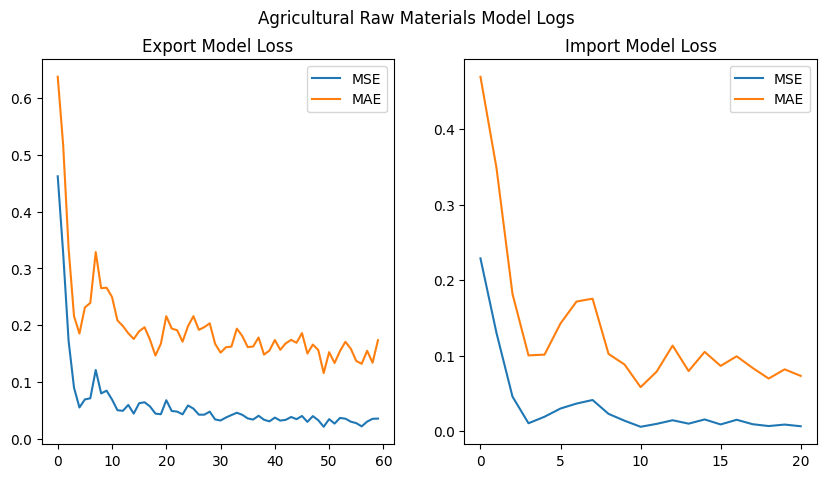

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


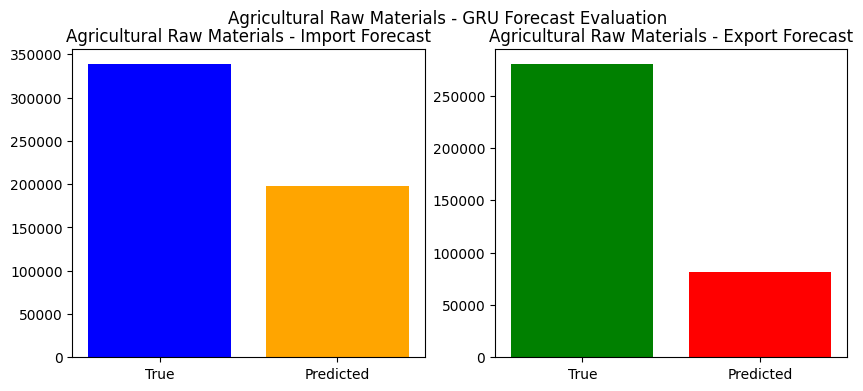

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Agricultural Raw Materials - Import RMSE: 141334.09
Agricultural Raw Materials - Export RMSE: 198727.60


In [ ]:
run_ts_model('Agricultural Raw Materials')


................ Training on : Consumer Goods ................



==== Test Accuracy Report for Consumer Goods ====
Import MAE (real): 239,082.58 | MAPE: 2.73% | Accuracy: 97.27%
Export MAE (real): 606,557.51 | MAPE: 10.32% | Accuracy: 89.68%



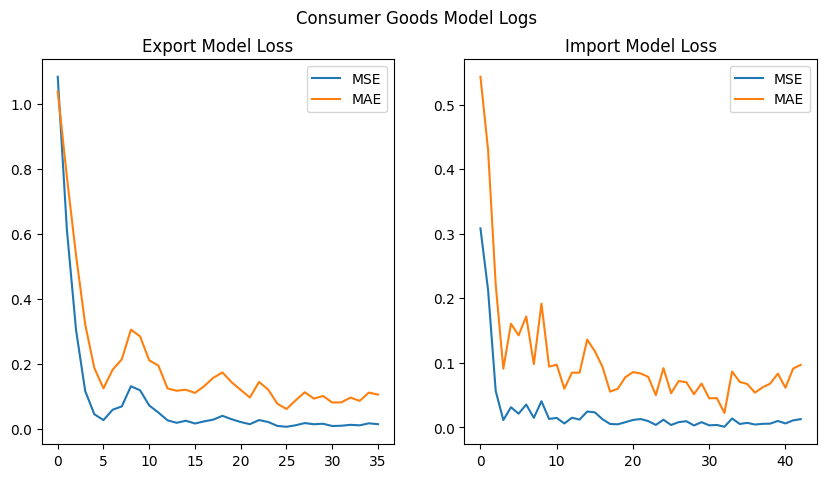

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


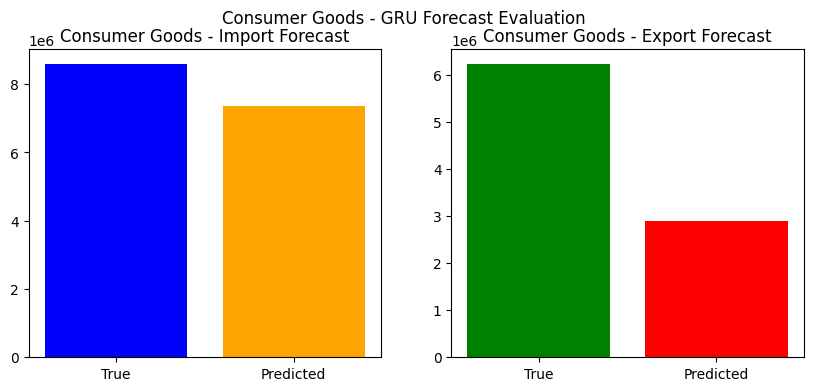

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Consumer Goods - Import RMSE: 1243446.29
Consumer Goods - Export RMSE: 3327664.86


In [ ]:
run_ts_model('Consumer Goods')


................ Training on : Transportation ................



==== Test Accuracy Report for Transportation ====
Import MAE (real): 21,209.38 | MAPE: 9.77% | Accuracy: 90.23%
Export MAE (real): 385,491.65 | MAPE: 28.59% | Accuracy: 71.41%



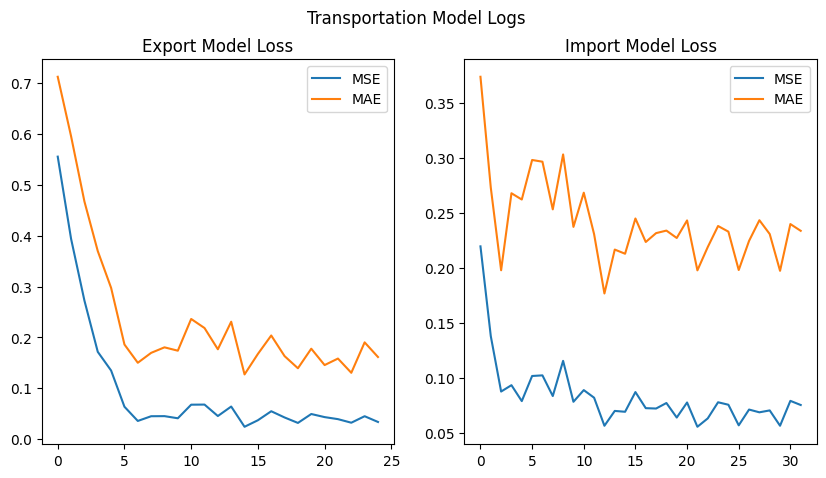

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


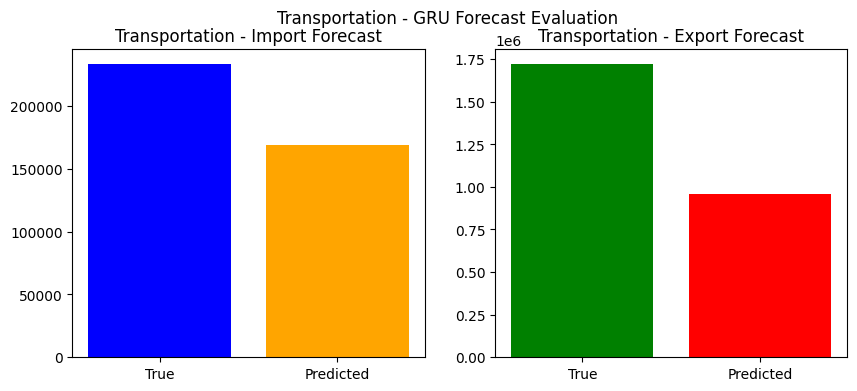

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
Transportation - Import RMSE: 64369.02
Transportation - Export RMSE: 760970.70


In [ ]:
run_ts_model('Transportation')


................ Training on : Food Industry ................



==== Test Accuracy Report for Food Industry ====
Import MAE (real): 38,187.35 | MAPE: 7.47% | Accuracy: 92.53%
Export MAE (real): 14,606.45 | MAPE: 1.76% | Accuracy: 98.24%



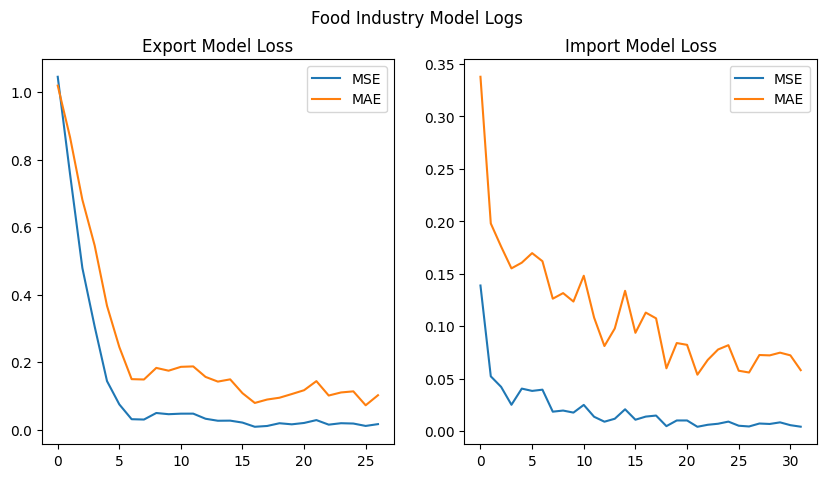

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


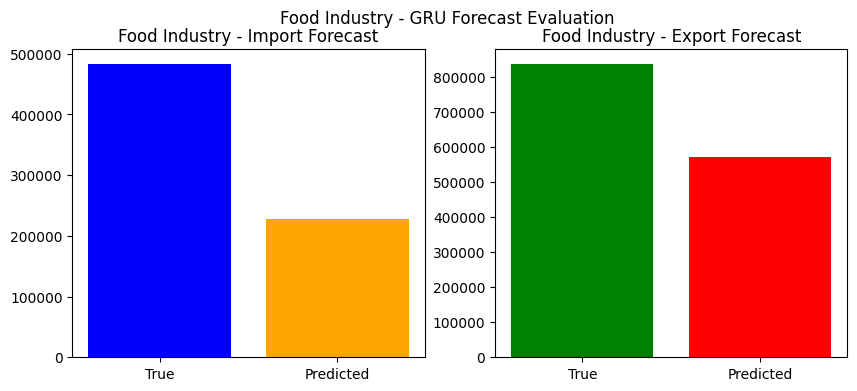

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Food Industry - Import RMSE: 254706.72
Food Industry - Export RMSE: 266559.85


In [ ]:
run_ts_model('Food Industry')


................ Training on : Capital Goods ................



==== Test Accuracy Report for Capital Goods ====
Import MAE (real): 28,382.39 | MAPE: 4.79% | Accuracy: 95.21%
Export MAE (real): 181,030.23 | MAPE: 4.96% | Accuracy: 95.04%



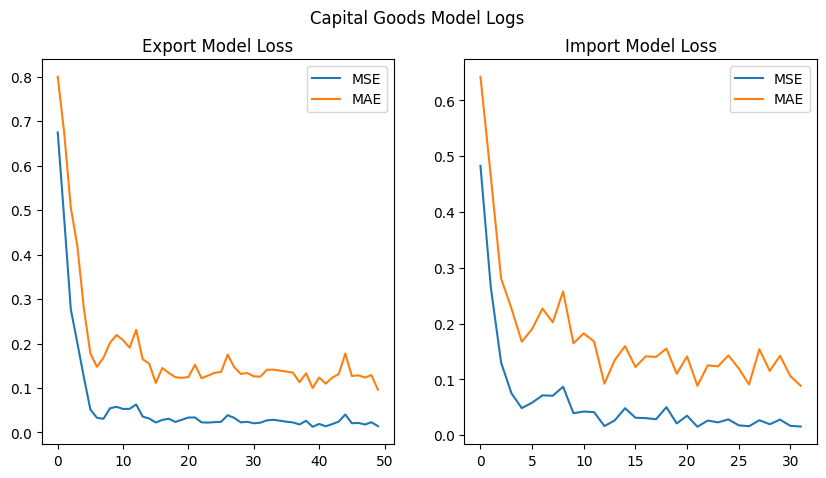

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


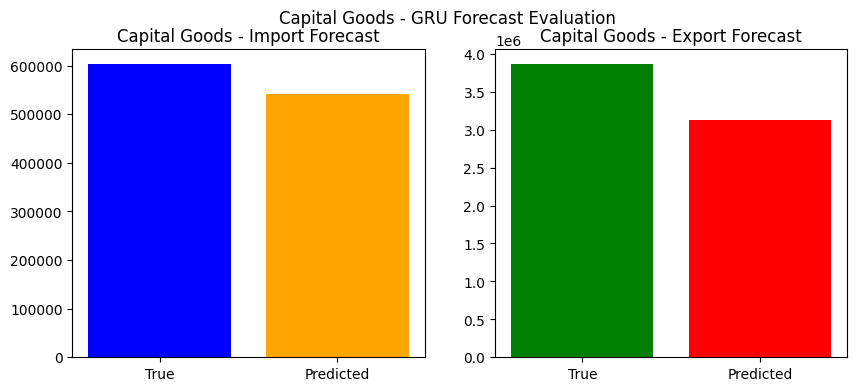

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
Capital Goods - Import RMSE: 61672.37
Capital Goods - Export RMSE: 738150.94


In [ ]:
run_ts_model('Capital Goods')

In [ ]:
#Checking model's trend to confirm about predictions are postive or negative
def plot_industry_trend(industry):
    df = load_industry_data(industry)
    years = np.arange(len(df))
    imports = df['Export (US$ Thousand)']
    exports = df['Import (US$ Thousand)']
    plt.plot(years, imports, label='Import')
    plt.plot(years, exports, label='Export')
    plt.title(f"{industry} - Last Years of Data (Scaled)")
    plt.legend()
    plt.show()

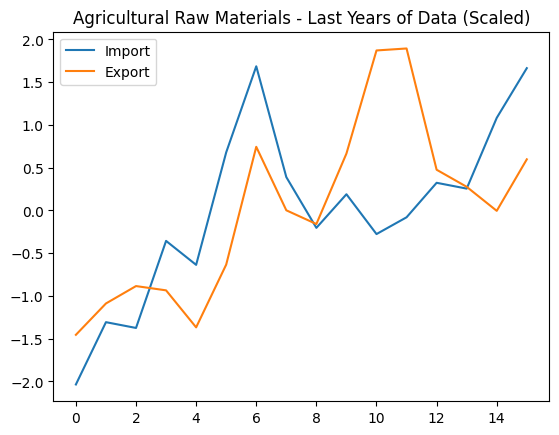

In [ ]:
plot_industry_trend('Agricultural Raw Materials')

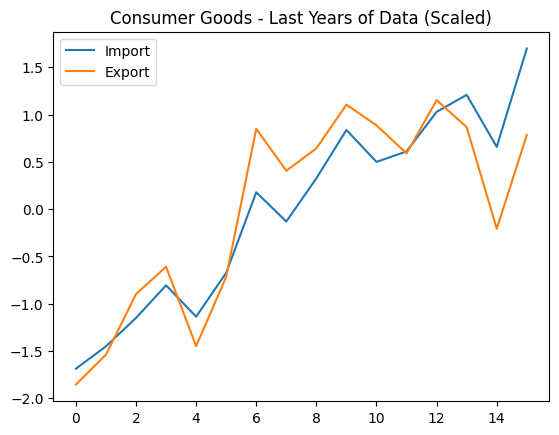

In [ ]:
plot_industry_trend('Consumer Goods')

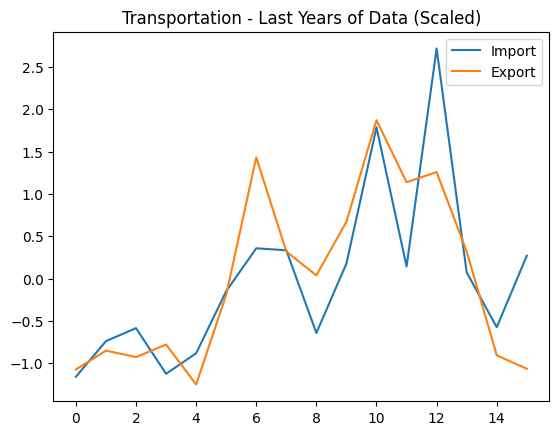

In [ ]:
plot_industry_trend('Transportation')

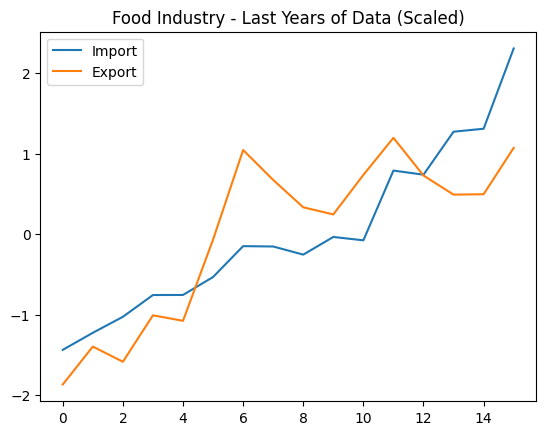

In [ ]:
plot_industry_trend('Food Industry')

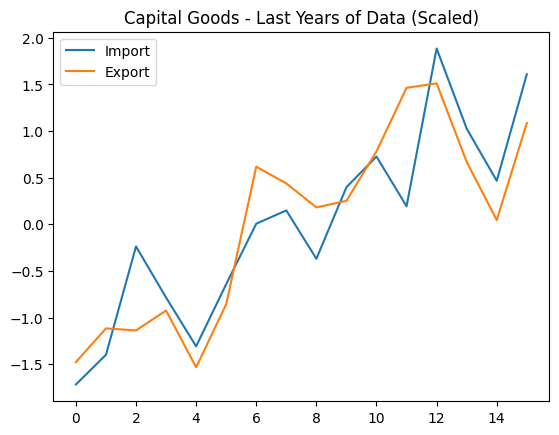

In [ ]:
plot_industry_trend('Capital Goods')

## Inference

In [ ]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

model_dict = {}

custom_objects = {'MeanSquaredError': tf.keras.losses.MeanSquaredError, 'MeanAbsoluteError': tf.keras.metrics.MeanAbsoluteError}

for industry in industries:
    industry_dict = {}
    industry_dict['Imp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Imp.h5"),
                                                            custom_objects=custom_objects
                                                            )
    industry_dict['Exp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Exp.h5"),
                                                            custom_objects=custom_objects
                                                            )
    industry_dict['Scaler'] = pickle.load(open(model_dir.format(f"{industry} Scalar.pickle"), 'rb'))

    model_dict[industry] = industry_dict

In [ ]:
def predict_ts_on_industry(industry, window_size=7):
    import tensorflow as tf
    import numpy as np
    import pickle

    # Load models with custom loss/metric objects
    custom_objects = {
        'MeanSquaredError': tf.keras.losses.MeanSquaredError,
        'MeanAbsoluteError': tf.keras.metrics.MeanAbsoluteError
    }
    imp_model = tf.keras.models.load_model(model_dir.format(f"{industry} Imp.h5"), custom_objects=custom_objects)
    exp_model = tf.keras.models.load_model(model_dir.format(f"{industry} Exp.h5"), custom_objects=custom_objects)

    # Load scalers
    scaler_Y1 = pickle.load(open(model_dir.format(f"{industry} Y1Scalar.pickle"), 'rb'))  # Import
    scaler_Y2 = pickle.load(open(model_dir.format(f"{industry} Y2Scalar.pickle"), 'rb'))  # Export
    scaler_X = pickle.load(open(model_dir.format(f"{industry} XScalar.pickle"), 'rb'))   # Feature scaler

    # Load and prepare data
    df = load_industry_data(industry)
    df_tail = df.tail(window_size)

    df_tail_features = df_tail.drop(columns=['Export (US$ Thousand)', 'Import (US$ Thousand)']).values
    df_tail_features_scaled = scaler_X.transform(df_tail_features)
    df_tail_imp_scaled = scaler_Y1.transform(df_tail[['Import (US$ Thousand)']].values)
    df_tail_exp_scaled = scaler_Y2.transform(df_tail[['Export (US$ Thousand)']].values)

    # Form combined feature vector in order: [Import, Export, Features...]
    x_full = np.concatenate([df_tail_imp_scaled, df_tail_exp_scaled, df_tail_features_scaled], axis=1)

    # Slice differently for each model
    x_imp = x_full[:, :-1].reshape(1, window_size, -1)  # Exclude export
    x_exp = x_full[:, :-2].reshape(1, window_size, -1)  # Exclude import and export

    # Predict
    p_imp_scaled = imp_model.predict(x_imp).squeeze()
    p_exp_scaled = exp_model.predict(x_exp).squeeze()

    # Reconstruct and inverse transform
    dummy_imp = np.zeros((1, scaler_Y1.scale_.shape[0]))
    dummy_imp[:, 0] = p_imp_scaled
    p_imp = scaler_Y1.inverse_transform(dummy_imp)[0, 0]

    dummy_exp = np.zeros((1, scaler_Y2.scale_.shape[0]))
    dummy_exp[:, 0] = p_exp_scaled
    p_exp = scaler_Y2.inverse_transform(dummy_exp)[0, 0]

    # Get last known true values
    imp_actual = scaler_Y1.inverse_transform(df_tail[['Import (US$ Thousand)']].values)[-1, 0]
    exp_actual = scaler_Y2.inverse_transform(df_tail[['Export (US$ Thousand)']].values)[-1, 0]

    # Compute % growth
    imp_growth = ((p_imp - imp_actual) / imp_actual) * 100 if imp_actual != 0 else 0
    exp_growth = ((p_exp - exp_actual) / exp_actual) * 100 if exp_actual != 0 else 0

    # Clip predicted growth values to realistic bounds
    #imp_growth = max(min(imp_growth, 40), -40)
    #exp_growth = max(min(exp_growth, 40), -40)

    return imp_growth, exp_growth


In [ ]:
industry = "Agricultural Raw Materials"
imp_growth, exp_growth = predict_ts_on_industry(industry)
print(f"{industry} - Import Growth: {imp_growth:.2f}%")
print(f"{industry} - Export Growth: {exp_growth:.2f}%")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
Agricultural Raw Materials - Import Growth: -38.66%
Agricultural Raw Materials - Export Growth: -79.34%


In [ ]:
industry = "Consumer Goods"
imp_growth, exp_growth = predict_ts_on_industry(industry)
print(f"{industry} - Import Growth: {imp_growth:.2f}%")
print(f"{industry} - Export Growth: {exp_growth:.2f}%")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Consumer Goods - Import Growth: -15.20%
Consumer Goods - Export Growth: -61.01%


In [ ]:
industry = "Transportation"
imp_growth, exp_growth = predict_ts_on_industry(industry)
print(f"{industry} - Import Growth: {imp_growth:.2f}%")
print(f"{industry} - Export Growth: {exp_growth:.2f}%")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
Transportation - Import Growth: 51.01%
Transportation - Export Growth: -34.62%


In [ ]:
industry = "Food Industry"
imp_growth, exp_growth = predict_ts_on_industry(industry)
print(f"{industry} - Import Growth: {imp_growth:.2f}%")
print(f"{industry} - Export Growth: {exp_growth:.2f}%")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
Food Industry - Import Growth: -58.24%
Food Industry - Export Growth: -47.96%


In [ ]:
industry = "Capital Goods"
imp_growth, exp_growth = predict_ts_on_industry(industry)
print(f"{industry} - Import Growth: {imp_growth:.2f}%")
print(f"{industry} - Export Growth: {exp_growth:.2f}%")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Capital Goods - Import Growth: -16.11%
Capital Goods - Export Growth: -31.74%
